#Analysis of CrowdFlower job #754530: abstract-level chemical-induced disease relation extraction for BioCreative V

Tong Shu Li<br>
Created on Tuesday 2015-07-21<br>
Last updated 2015-07-28

Previous work with CrowdFlower tasks #746297 and #748223 showed that:

1. Workers performed best on relations which were sentence bound.
2. Workers missed some relations when multiple relations were presented.
3. Workers picked out the easiest relations to verify when multiple relations were presented.
4. Concept name replacement with the semantic type had little influence on performance.

Based on these observations, I decided to make the following changes:

1. Split the task into two subtasks: one where the relation is sentence bound, and one where the relation is not sentence bound. While the underlying task is almost identical, this allows payments to be structured differently and hopefully for tasks to be processed faster.
2. Reduce the number of relations to verify for each passage of text from five to one. This allows each judgement to be simplified to a binary judgement.

This notebook will analyze the results of the abstract-level task.

Parameter | Value
--- | ---
Job ID | #754530
Rows per page | 5
Judgements per row | 5
Payment per page | 25 cents USD
Contributor level | 2
Minimum time per page | 30 seconds
Minimum accuracy threshold | 70%
Number of test questions | 14
Date of launch | 5:00 pm on Monday, July 20, 2015
Date of completion | 9:00 am on Tuesday, July 21, 2015
Total cost before bonuses | \$43.20 USD
Total cost after bonuses | $43.32 USD

---

In [1]:
from __future__ import division
from collections import Counter
from collections import defaultdict
from IPython.display import Image
import matplotlib as plt
import os
import pandas as pd
import pickle

In [2]:
matplotlib inline

In [3]:
%%bash

rm src/get_AUC_value.pyc

In [4]:
from src.filter_data import filter_data
from src.data_model import parse_input
from src.data_model import Relation
from src.get_AUC_value import get_AUC_value
from src.F_score import *
from src.aggregate_results import *

###Read the results of job #754530:

In [5]:
settings = {
    "loc": "data/crowdflower/results",
    "fname": "job_754530_full_with_untrusted.csv",
    "data_subset": "normal",
    "min_accuracy": 0.7,
    "max_accuracy": 1.0
}

raw_data = filter_data(settings)

In [6]:
raw_data.shape

(485, 27)

In [7]:
raw_data.head()

,_unit_id,_created_at,_golden,_id,_missed,_started_at,_tainted,_channel,_trust,_worker_id,...,disease_id,disease_name,drug_id,drug_name,form_abstract,form_title,pmid,uniq_id,verify_relationship_gold,worker_confidence_gold
0,756359591,7/21/2015 00:30:42,False,1694432011,NaN,7/21/2015 00:29:52,False,gifthunterclub,0.7857,27920569,...,D017180,"<span class=""disease"">ventricular tachycardia<...",C063968,"<span class=""chemical"">E4031</span>",1. Torsades de pointes (TDP) is a potentially ...,Pharmacokinetic/pharmacodynamic assessment of ...,11569530,bcv_hard_0,NaN,NaN
1,756359591,7/21/2015 00:32:50,False,1694432585,NaN,7/21/2015 00:29:59,False,clixsense,1.0000,20404755,...,D017180,"<span class=""disease"">ventricular tachycardia<...",C063968,"<span class=""chemical"">E4031</span>",1. Torsades de pointes (TDP) is a potentially ...,Pharmacokinetic/pharmacodynamic assessment of ...,11569530,bcv_hard_0,NaN,NaN
2,756359591,7/21/2015 00:35:07,False,1694433298,NaN,7/21/2015 00:30:09,False,instagc,0.8182,27770607,...,D017180,"<span class=""disease"">ventricular tachycardia<...",C063968,"<span class=""chemical"">E4031</span>",1. Torsades de pointes (TDP) is a potentially ...,Pharmacokinetic/pharmacodynamic assessment of ...,11569530,bcv_hard_0,NaN,NaN
3,756359591,7/21/2015 00:35:25,False,1694433370,NaN,7/21/2015 00:30:13,False,neodev,0.9091,33534395,...,D017180,"<span class=""disease"">ventricular tachycardia<...",C063968,"<span class=""chemical"">E4031</span>",1. Torsades de pointes (TDP) is a potentially ...,Pharmacokinetic/pharmacodynamic assessment of ...,11569530,bcv_hard_0,NaN,NaN
4,756359591,7/21/2015 01:09:42,False,1694443215,NaN,7/21/2015 01:00:51,False,points4rewards,0.8889,20113482,...,D017180,"<span class=""disease"">ventricular tachycardia<...",C063968,"<span class=""chemical"">E4031</span>",1. Torsades de pointes (TDP) is a potentially ...,Pharmacokinetic/pharmacodynamic assessment of ...,11569530,bcv_hard_0,NaN,NaN


###Preprocessing:

This time, the judgements were binary, and therefore there is no ability for inconsistency in a single worker's judgements. Therefore we do not need to do the consistency check that we performed for jobs #746297 and #748223.

We will look at the comments before proceeding to analysis.

###Comments:

In [8]:
raw_data["comment_box"].unique()

array([nan, 'this test question is wrong',
       'All three chemicals {(131 mg/m(2) for paclitaxel (97.3%), 117 mg/m(2) for cisplatin (97.3%), and 1378 mg/m(2) for gemcitabine (86.2% )}  listed are  responsible for the cause of disease.',
       'wrong test question',
       'All the above three chemicals [31 mg/m(2) for paclitaxel (97.3%), 117 mg/m(2) for cisplatin (97.3%), and 1378 mg/m(2) for gemcitabine (86.2%)] are responsible in causing the disease .',
       'Proofs provided aren-t strong enough to relate the disease to the drug',
       'This may well be a particularly notable finding in Asian people.'], dtype=object)

###Test question contentions:

Three test questions had a few contentions:

PMID | Unit ID | Unique ID
--- | --- | ---
11569530 | 756407963 | bcv_hard_1
15632880 | 756407799 | bcv_hard_49
11135224 | 756400982 | bcv_hard_5

For bcv_hard_1, the question asked what the relationship between "cisapride" and "ventricular tachycardia" was. The text clearly says that cisapride causes TDP (Torsades de pointes), and that TDP "is a potentially fatal ventricular tachycardia".

Some workers contend that the text is saying that cisapride indirectly causes ventricular tachycardia through TDP, instead of no relationship. I put "no relation" as the correct answer because ventricular tachycardia is a superclass of TDP, and therefore the causation cannot be direct. The problem now lies in whether we should count this as an indirect cause, different from when the text says something like "drug induced disease A causes disease B". The real problem is whether we treat the "is a" relationship as a "causes" relationship.

At this time I have not determined the best way to resolve this conflict. The gold standard says that the relationship does not exist.

For bcv_hard_49, the question is what this passage of text means:
> Sixty-seven of 926 patients (7.2%) required discontinuation of spironolactone due to hyperkalemia (n = 33) or renal failure (n = 34). Patients who developed hyperkalemia were older and more likely to have diabetes, had higher baseline serum potassium levels and lower baseline potassium supplement doses, and were more likely to be treated with beta-blockers than controls (n = 134).

I believe that this means that the patients had diabetes prior to being given the drug, and not that they developed diabetes after receiving the drug, as some workers contended. Specifically the workers chose the indirect relationship choice of spironolactone -> hyperkalemia -> diabetes.

Finally, the last contention for bcv_hard_5 was to say that paclitaxel does not cause death, since it is the combination of three drugs which resulted in one death. This is a bit problematic, since the gold also says that this relation does not exist, but as for the contention, I made it clear in the instructions that the drug could work by itself or with other drugs, so I did not forgive the contentions.

---

###Result aggregation:

Two methods of voting aggregation are possible for each individual work unit:

1. Majority voting: crowd's answer is whatever the most voted answer was. Confidence score for top answer is the % of people who chose the top answer.
2. Any number of positive votes: since we only want to know whether the relationship is true or not, we count the total number of positive votes for each work unit. The confidence score is the % of people who chose the positive answer.

In [9]:
def norm_conf_score(dataset):
    def convert(val):
        mapping = {
            "very_confident": 4,
            "confident": 3,
            "not_too_confident": 2,
            "not_confident": 1
        }
        return mapping[val]
    
    return sum(dataset["worker_confidence"].map(convert)) / len(dataset)

In [10]:
res = aggregate_results("uniq_id", "verify_relationship", raw_data, "majority_vote", ["pmid", "_unit_id"])

In [11]:
res.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id
0,bcv_hard_0,no_relation,4.4019,5,1.000000,11569530,756359591
2,bcv_hard_1,no_relation,1.7142,2,0.404493,11569530,756359592
1,bcv_hard_1,yes_direct,1.6904,2,0.398877,11569530,756359592
0,bcv_hard_1,yes_indirect,0.8333,1,0.196630,11569530,756359592
0,bcv_hard_10,yes_direct,4.4417,5,1.000000,11135224,756359601


###Dealing with yes_indirect relationships:

There are two ways to map the results:

1. Convert yes_indirect to a "yes"
2. Convert yes_indirect to a "no"

In [12]:
mapping1 = {
    "yes_direct": "yes_relation",
    "yes_indirect": "yes_relation",
    "no_relation": "no_relation"
}

mapping2 = {
    "yes_direct": "yes_relation",
    "yes_indirect": "no_relation",
    "no_relation": "no_relation"
}

res_yes = aggregate_results("uniq_id", "verify_relationship", raw_data, "majority_vote",
                            ["pmid", "_unit_id"], mapping = mapping1)

res_no = aggregate_results("uniq_id", "verify_relationship", raw_data, "majority_vote",
                           ["pmid", "_unit_id"], mapping = mapping2)

In [13]:
res_yes.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id
0,bcv_hard_0,no_relation,4.4019,5,1.000000,11569530,756359591
0,bcv_hard_1,yes_relation,2.5237,3,0.595507,11569530,756359592
1,bcv_hard_1,no_relation,1.7142,2,0.404493,11569530,756359592
0,bcv_hard_10,yes_relation,4.4417,5,1.000000,11135224,756359601
0,bcv_hard_11,yes_relation,3.5659,4,0.819446,11135224,756359602


In [14]:
res_no.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id
0,bcv_hard_0,no_relation,4.4019,5,1.000000,11569530,756359591
1,bcv_hard_1,no_relation,2.5475,3,0.601123,11569530,756359592
0,bcv_hard_1,yes_relation,1.6904,2,0.398877,11569530,756359592
0,bcv_hard_10,yes_relation,4.4417,5,1.000000,11135224,756359601
0,bcv_hard_11,yes_relation,3.5659,4,0.819446,11135224,756359602


---

###Read the gold standard:

In [15]:
if os.path.exists("data/training/parsed_training_set.pickle"):
    print "Reading cached version of training set"
    with open("data/training/parsed_training_set.pickle", "rb") as fin:
        training_data = pickle.load(fin)
else:
    training_data = parse_input("data/training", "CDR_TrainingSet.txt")
    with open("data/training/parsed_training_set.pickle", "wb") as fout:
        pickle.dump(training_data, fout)

Reading cached version of training set


In [16]:
testset_pmids = set(raw_data["pmid"].unique())

In [17]:
testset_pmids

{1130930,
 1378968,
 1835291,
 2096243,
 2265898,
 2375138,
 3800626,
 6666578,
 7449470,
 7582165,
 8590259,
 8595686,
 9522143,
 10835440,
 11135224,
 11569530,
 12198388,
 15602202,
 15632880,
 16167916,
 16337777,
 17241784,
 17261653,
 18631865}

In [18]:
def get_subset(dataset, papers):
    return {paper.pmid : paper for paper in papers if paper.pmid in dataset}

testset = get_subset(testset_pmids, training_data)

We have fewer than the original 30 work units because some of them had relations which were exclusively sentence-bound.

In [19]:
len(testset)

24

---

###Evaluate crowd performance against the gold standard:

We will now check how the crowd did against the gold standard. To do this we will take the top answer as the official crowd response and compare it to the gold.

In [20]:
def get_class(in_gold, crowd_resp):
    mapping = {
        True : {
            "yes_relation": "true_pos",
            "no_relation": "false_neg"
        },
        False : {
            "yes_relation": "false_pos",
            "no_relation": "true_neg"
        }
    }
    
    return mapping[in_gold][crowd_resp]

In [21]:
def evaluate_performance(results, raw_data, gold_std):
    """
    Summarizes the crowd's performance against the gold standard
    and returns a summary dataframe.
    """
    res = defaultdict(list)
    
    for uniq_id, group in results.groupby("uniq_id"):
        assert len(group["pmid"].unique()) == 1
        pmid = group["pmid"].iloc[0]
        
        # grab the relation pair for this work unit
        datarow = raw_data.query("uniq_id == '{0}'".format(uniq_id)).iloc[0]
        
        chemical_id = datarow["drug_id"]
        disease_id = datarow["disease_id"]
        
        rel = Relation(pmid, chemical_id, disease_id)
        
        in_gold = int(gold_std[pmid].has_relation(rel))
        
        # now we check if the crowd's answer matched the gold
        crowd_ans = group["verify_relationship"].iloc[0]
        assert crowd_ans in ["yes_relation", "no_relation"], crowd_ans
        
        res["pmid"].append(pmid)
        res["uniq_id"].append(uniq_id)
        res["unit_id"].append(datarow["_unit_id"])
        
        res["chemical_id"].append(chemical_id)
        res["disease_id"].append(disease_id)
        
        res["in_gold"].append(in_gold)
        res["top_crowd_response"].append(crowd_ans)
        
        res["num_votes"].append(group["num_votes"].iloc[0])
        res["percent_agree"].append(group["percent_agree"].iloc[0])
        
        res["ans_class"].append(get_class(in_gold, crowd_ans))
        
        res["norm_conf"].append(norm_conf_score(raw_data.query("uniq_id == '{0}'".format(uniq_id))))
        
    return pd.DataFrame(res)

In [22]:
perf_yes = evaluate_performance(res_yes, raw_data, testset)

In [23]:
perf_yes.head()

,ans_class,chemical_id,disease_id,in_gold,norm_conf,num_votes,percent_agree,pmid,top_crowd_response,uniq_id,unit_id
0,true_neg,C063968,D017180,0,3.2,5,1.000000,11569530,no_relation,bcv_hard_0,756359591
1,false_pos,D020117,D017180,0,3.4,3,0.595507,11569530,yes_relation,bcv_hard_1,756359592
2,true_pos,C056507,D013921,1,3.4,5,1.000000,11135224,yes_relation,bcv_hard_10,756359601
3,false_pos,C056507,D003643,0,3.2,4,0.819446,11135224,yes_relation,bcv_hard_11,756359602
4,true_pos,C056507,D009503,1,3.8,4,0.784342,11135224,yes_relation,bcv_hard_12,756359603


In [24]:
perf_no = evaluate_performance(res_no, raw_data, testset)

In [25]:
perf_no.head()

,ans_class,chemical_id,disease_id,in_gold,norm_conf,num_votes,percent_agree,pmid,top_crowd_response,uniq_id,unit_id
0,true_neg,C063968,D017180,0,3.2,5,1.000000,11569530,no_relation,bcv_hard_0,756359591
1,true_neg,D020117,D017180,0,3.4,3,0.601123,11569530,no_relation,bcv_hard_1,756359592
2,true_pos,C056507,D013921,1,3.4,5,1.000000,11135224,yes_relation,bcv_hard_10,756359601
3,false_pos,C056507,D003643,0,3.2,4,0.819446,11135224,yes_relation,bcv_hard_11,756359602
4,true_pos,C056507,D009503,1,3.8,4,0.784342,11135224,yes_relation,bcv_hard_12,756359603


In [26]:
def flip_score(choice_column, negative_choice, score_column, dataframe):
    """
    If using majority vote, and the top choice is the negative vote
    (for a binary judgement work unit), then this function flips the
    percent_agreement score to be negative.
    
    choice_column = name of the column containing the binary judgement workers make
    negative_choice = value of the negative judgement made by the workers in choice_column
    score_column = name of the column containing the score we want to selectively invert
    """
    def flip(datarow):
        return -datarow[score_column] if datarow[choice_column] == negative_choice else datarow[score_column]
    
    # adds a column to the original dataframe!
    dataframe.loc[:, "threshold_score"] = dataframe[[choice_column, score_column]].apply(flip, axis = 1)
    return dataframe

In [27]:
perf_yes = flip_score("top_crowd_response", "no_relation", "percent_agree", perf_yes)

In [28]:
perf_yes.head()

,ans_class,chemical_id,disease_id,in_gold,norm_conf,num_votes,percent_agree,pmid,top_crowd_response,uniq_id,unit_id,threshold_score
0,true_neg,C063968,D017180,0,3.2,5,1.000000,11569530,no_relation,bcv_hard_0,756359591,-1.000000
1,false_pos,D020117,D017180,0,3.4,3,0.595507,11569530,yes_relation,bcv_hard_1,756359592,0.595507
2,true_pos,C056507,D013921,1,3.4,5,1.000000,11135224,yes_relation,bcv_hard_10,756359601,1.000000
3,false_pos,C056507,D003643,0,3.2,4,0.819446,11135224,yes_relation,bcv_hard_11,756359602,0.819446
4,true_pos,C056507,D009503,1,3.8,4,0.784342,11135224,yes_relation,bcv_hard_12,756359603,0.784342


In [29]:
perf_no = flip_score("top_crowd_response", "no_relation", "percent_agree", perf_no)

In [30]:
perf_no.head()

,ans_class,chemical_id,disease_id,in_gold,norm_conf,num_votes,percent_agree,pmid,top_crowd_response,uniq_id,unit_id,threshold_score
0,true_neg,C063968,D017180,0,3.2,5,1.000000,11569530,no_relation,bcv_hard_0,756359591,-1.000000
1,true_neg,D020117,D017180,0,3.4,3,0.601123,11569530,no_relation,bcv_hard_1,756359592,-0.601123
2,true_pos,C056507,D013921,1,3.4,5,1.000000,11135224,yes_relation,bcv_hard_10,756359601,1.000000
3,false_pos,C056507,D003643,0,3.2,4,0.819446,11135224,yes_relation,bcv_hard_11,756359602,0.819446
4,true_pos,C056507,D009503,1,3.8,4,0.784342,11135224,yes_relation,bcv_hard_12,756359603,0.784342


---

###Evaluating performance of majority voting and confidence scoring metric A:

In [31]:
fname = "data/roc/job_754530_majority_vote_indirect_is_yes.png"
title = "ROC for job 754530 (abstract level); majority vote, indirect means yes"
get_AUC_value(perf_yes, "threshold_score", "in_gold", fname, title)

0.9260651629072681

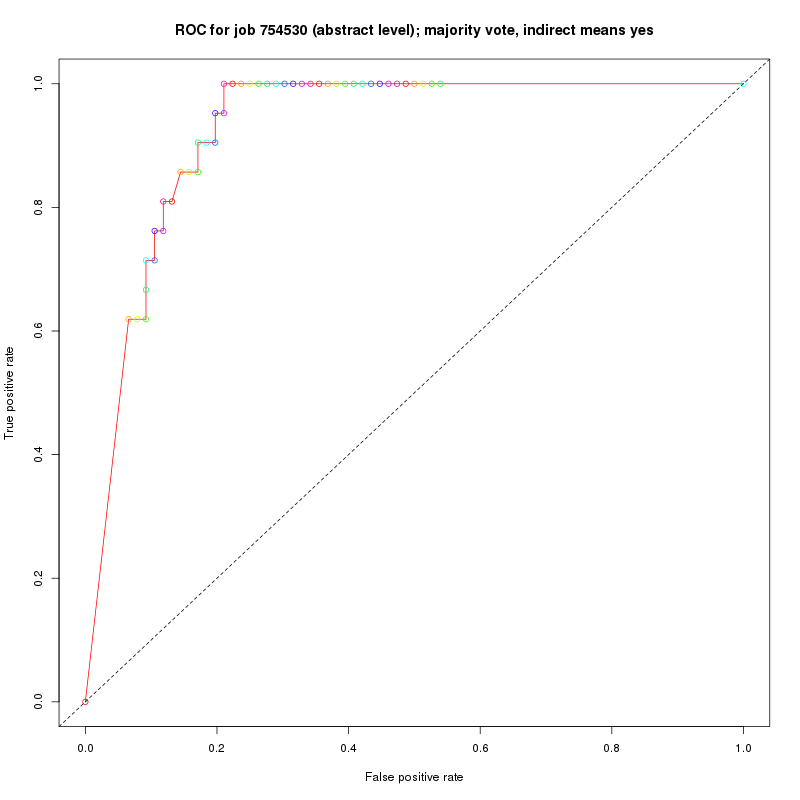

In [32]:
Image(fname)

In [33]:
max_F_score("threshold_score", "in_gold", perf_yes)

F_score      0.724138
precision    0.567568
recall       1.000000
threshold    0.596415
Name: 16, dtype: float64

In [34]:
fname = "data/roc/job_754530_majority_vote_indirect_is_no.png"
title = "ROC for job 754530 (abstract level); majority vote, indirect means no"
get_AUC_value(perf_no, "threshold_score", "in_gold", fname, title)

0.9329573934837092

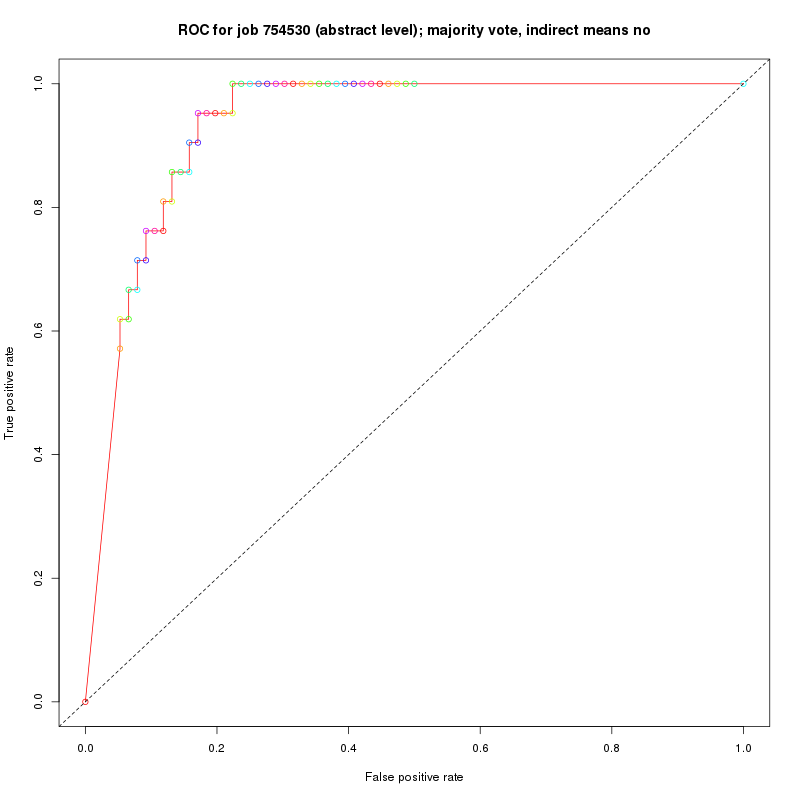

In [35]:
Image(fname)

In [36]:
max_F_score("threshold_score", "in_gold", perf_no)

F_score      0.740741
precision    0.606061
recall       0.952381
threshold    0.596415
Name: 16, dtype: float64

###Performance if we use majority voting:

In [37]:
def perf_statistics(perf_summary):
    """
    Calculates true pos, false pos, true neg, and false neg
    values for a performance summary dataframe.
    
    Also calculates precision, recall, and F score.
    """
    true_pos = len(perf_summary.query("ans_class == 'true_pos'"))
    true_neg = len(perf_summary.query("ans_class == 'true_neg'"))
    
    false_pos = len(perf_summary.query("ans_class == 'false_pos'"))
    false_neg = len(perf_summary.query("ans_class == 'false_neg'"))
    
    assert true_pos + true_neg + false_pos + false_neg == len(perf_summary)
    
    print "true pos", true_pos
    print "true neg", true_neg
    print "false pos", false_pos
    print "false neg", false_neg
    print
    
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    
    print "precision", precision
    print "recall", recall
    
    print "F score", F_score(precision, recall)

In [38]:
perf_statistics(perf_yes)

true pos 21
true neg 55
false pos 21
false neg 0

precision 0.5
recall 1.0
F score 0.666666666667


In [39]:
perf_statistics(perf_no)

true pos 21
true neg 58
false pos 18
false neg 0

precision 0.538461538462
recall 1.0
F score 0.7


---

###We also asked the workers to rate their confidence in their work. Was that useful information?

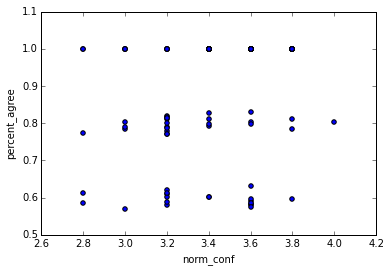

In [40]:
perf_no.plot(kind = "scatter", x = "norm_conf", y = "percent_agree")

The consensus among the workers did not increase as the aggregate confidence of the workers increased. Workers are just as likely to be confident in a wrong answer as a correct one.

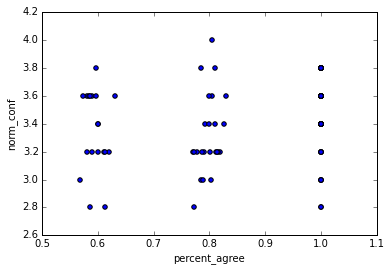

In [41]:
perf_no.plot(kind = "scatter", x = "percent_agree", y = "norm_conf")

###Confidence vs. answer class:

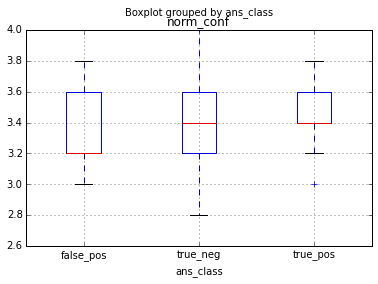

In [42]:
perf_no.boxplot(column = "norm_conf", by = "ans_class")

Workers seemed equally confident in the true positives, the true negatives, and the false positives. It doesn't seem like the self-rated confidence is a good way of determining how likely a response is to be correct.

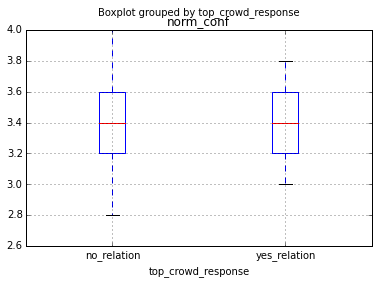

In [43]:
perf_no.boxplot(column = "norm_conf", by = "top_crowd_response")

Workers were qually confident in their votes regardless of the actual choice.

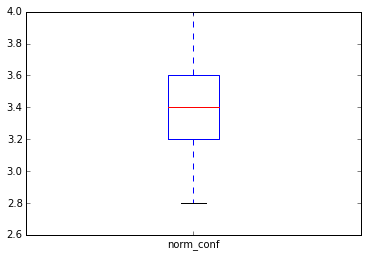

In [44]:
perf_no["norm_conf"].plot(kind = "box")

In [45]:
def convert(val):
    mapping = {
        "very_confident": 4,
        "confident": 3,
        "not_too_confident": 2,
        "not_confident": 1
    }
    return mapping[val]

Counter(raw_data["worker_confidence"])

Counter({'very_confident': 232, 'confident': 222, 'not_too_confident': 29, 'not_confident': 2})

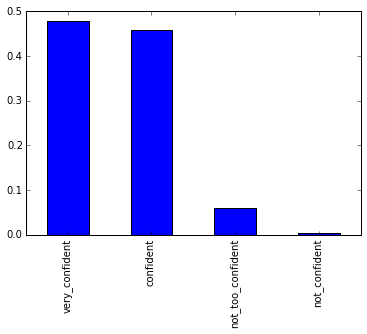

In [46]:
raw_data["worker_confidence"].value_counts(normalize = True).plot(kind = "bar")

The distribution of confidence votes were basically always either confident or very confident, which isn't terribly helpful. [Other data](http://www.crowdflower.com/blog/2011/09/confidence-bias-evidence-from-crowdsourcing) show that CrowdFlower workers in general tend to inflate their confidence.

It is however possible that I'm not using the confidence data properly. There may be smarter ways to use the confidence values to modulate the votes themselves.

###Thoughts:

The performance statistics don't seem too great at first glance. While it's good that there are no false negatives, I am concerned about the number of false positives in the results. 18 false positives in a set of 97 is 18.6%, which is pretty high. Let's look through these false positives by hand and see if there is something that we are missing.

The false positives:

In [47]:
false_positives = perf_no.query("ans_class == 'false_pos'")

In [48]:
false_positives.sort("percent_agree", ascending = False)

,ans_class,chemical_id,disease_id,in_gold,norm_conf,num_votes,percent_agree,pmid,top_crowd_response,uniq_id,unit_id,threshold_score
11,false_pos,D015742,D014474,0,3.6,5,1.000000,8595686,yes_relation,bcv_hard_19,756359610,1.000000
83,false_pos,D005839,D007674,0,3.2,5,1.000000,1130930,yes_relation,bcv_hard_84,756359675,1.000000
17,false_pos,D010862,D004827,0,3.4,5,1.000000,16337777,yes_relation,bcv_hard_24,756359615,1.000000
65,false_pos,D000305,D004342,0,3.6,5,1.000000,7582165,yes_relation,bcv_hard_68,756359659,1.000000
3,false_pos,C056507,D003643,0,3.2,4,0.819446,11135224,yes_relation,bcv_hard_11,756359602,0.819446
85,false_pos,D002512,D007674,0,3.0,4,0.803878,1130930,yes_relation,bcv_hard_86,756359677,0.803878
19,false_pos,D011318,D006319,0,3.4,4,0.791880,9522143,yes_relation,bcv_hard_26,756359617,0.791880
88,false_pos,D017963,D007674,0,3.0,4,0.788871,15602202,yes_relation,bcv_hard_89,756359680,0.788871
78,false_pos,D002945,D003643,0,3.2,4,0.786219,11135224,yes_relation,bcv_hard_8,756359599,0.786219
59,false_pos,D009241,D002318|D005767,0,3.6,3,0.630163,1835291,yes_relation,bcv_hard_62,756359653,0.630163


In [49]:
true_negatives = perf_no.query("ans_class == 'true_neg'")

In [50]:
true_negatives.sort("percent_agree", ascending = False)

,ans_class,chemical_id,disease_id,in_gold,norm_conf,num_votes,percent_agree,pmid,top_crowd_response,uniq_id,unit_id,threshold_score
0,true_neg,C063968,D017180,0,3.2,5,1.000000,11569530,no_relation,bcv_hard_0,756359591,-1.000000
74,true_neg,D003000,D006333,0,3.0,5,1.000000,17261653,no_relation,bcv_hard_76,756359667,-1.000000
41,true_neg,D049971,D006333,0,3.6,5,1.000000,15632880,no_relation,bcv_hard_46,756359637,-1.000000
42,true_neg,D049971,D006947,0,3.4,5,1.000000,15632880,no_relation,bcv_hard_47,756359638,-1.000000
43,true_neg,D049971,D003920,0,3.4,5,1.000000,15632880,no_relation,bcv_hard_48,756359639,-1.000000
44,true_neg,D013148,D003920,0,3.6,5,1.000000,15632880,no_relation,bcv_hard_49,756359640,-1.000000
52,true_neg,D012964,D014202,0,3.6,5,1.000000,12198388,no_relation,bcv_hard_56,756359647,-1.000000
54,true_neg,D011188,D012640,0,2.8,5,1.000000,12198388,no_relation,bcv_hard_58,756359649,-1.000000
55,true_neg,D011188,D014202,0,3.4,5,1.000000,12198388,no_relation,bcv_hard_59,756359650,-1.000000
72,true_neg,D003000,D001145,0,3.8,5,1.000000,17261653,no_relation,bcv_hard_74,756359665,-1.000000


In [51]:
true_positives = perf_no.query("ans_class == 'true_pos'")

In [52]:
true_positives.sort("percent_agree", ascending = False)

,ans_class,chemical_id,disease_id,in_gold,norm_conf,num_votes,percent_agree,pmid,top_crowd_response,uniq_id,unit_id,threshold_score
2,true_pos,C056507,D013921,1,3.4,5,1.000000,11135224,yes_relation,bcv_hard_10,756359601,1.000000
61,true_pos,D010248,D014581,1,3.2,5,1.000000,7582165,yes_relation,bcv_hard_64,756359655,1.000000
71,true_pos,D008874,D012140|D002318,1,3.6,5,1.000000,2375138,yes_relation,bcv_hard_73,756359664,1.000000
70,true_pos,D004317,D009202,1,3.4,5,1.000000,7449470,yes_relation,bcv_hard_72,756359663,1.000000
27,true_pos,C009265,D004827,1,3.4,5,1.000000,2265898,yes_relation,bcv_hard_33,756359624,1.000000
32,true_pos,D010396,D001018,1,3.6,5,1.000000,6666578,yes_relation,bcv_hard_38,756359629,1.000000
34,true_pos,D017239,D013921,1,3.0,5,1.000000,11135224,yes_relation,bcv_hard_4,756359595,1.000000
47,true_pos,C016986,D003316,1,3.4,5,1.000000,8590259,yes_relation,bcv_hard_51,756359642,1.000000
67,true_pos,D002945,D013921,1,3.4,5,1.000000,11135224,yes_relation,bcv_hard_7,756359598,1.000000
50,true_pos,C016986,D004774,1,3.0,5,1.000000,8590259,yes_relation,bcv_hard_54,756359645,1.000000


The agreement percentage for the false positives is markedly lower than that for both the true positives and the true negatives. This suggests to me again that the gold standard may be wrong and/or the question ambiguous/difficult.

(0.5, 1)

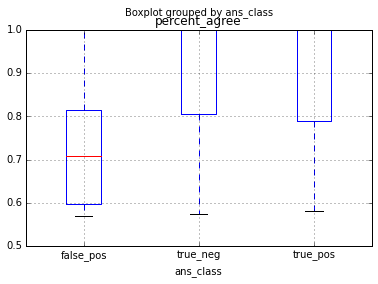

In [53]:
graph = perf_no.boxplot(column = "percent_agree", by = "ans_class")

graph.set_ylim((0.5, 1))

###Error analysis

Analysis of individual work units are contained in another notebook.

###Individual worker confidence:

Number of unique workers:

In [54]:
len(raw_data["_worker_id"].unique())

26

In [55]:
temp = defaultdict(list)

for worker_id, group in raw_data.groupby("_worker_id"):
    temp["worker_id"].append(worker_id)
    assert len(group["_trust"].unique()) == 1
    temp["trust"].append(group["_trust"].iloc[0])
    
    temp["units_done"].append(len(group))
    temp["norm_conf"].append(norm_conf_score(group))

In [56]:
workers = pd.DataFrame(temp)

In [57]:
workers

,norm_conf,trust,units_done,worker_id
0,4.000000,0.9286,36,11064916
1,3.500000,0.8889,16,20113482
2,3.833333,1.0000,36,20404755
3,3.000000,1.0000,4,21353389
4,3.500000,0.8571,8,22166359
5,4.000000,0.9000,20,24291759
6,3.250000,1.0000,4,25185311
7,3.000000,0.8571,36,26603936
8,2.571429,0.8182,21,27770607
9,3.000000,0.7857,36,27920569


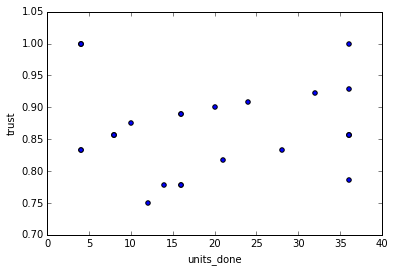

In [58]:
workers.plot(kind = "scatter", x = "units_done", y = "trust")

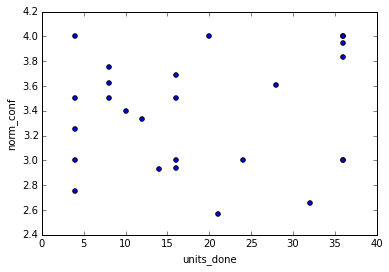

In [59]:
workers.plot(kind = "scatter", x = "units_done", y = "norm_conf")

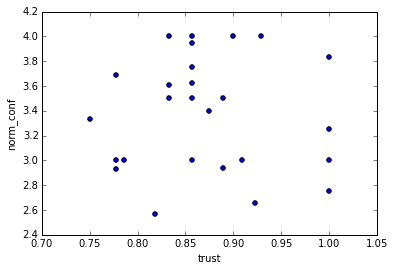

In [60]:
workers.plot(kind = "scatter", x = "trust", y = "norm_conf")

No real correlations of any sort between self-rated confidence, trust, and number of work units done.

###Maybe we can take only those work units which have high confidence scores:

In [61]:
perf_no["in_gold"] = perf_no["in_gold"].map(int)

In [62]:
fname = "data/roc/job_754530_worker_confidence.png"
title = "Worker confidence and its effect on AUC"
get_AUC_value(perf_no, "norm_conf", "in_gold", fname, title)

0.5119047619047619

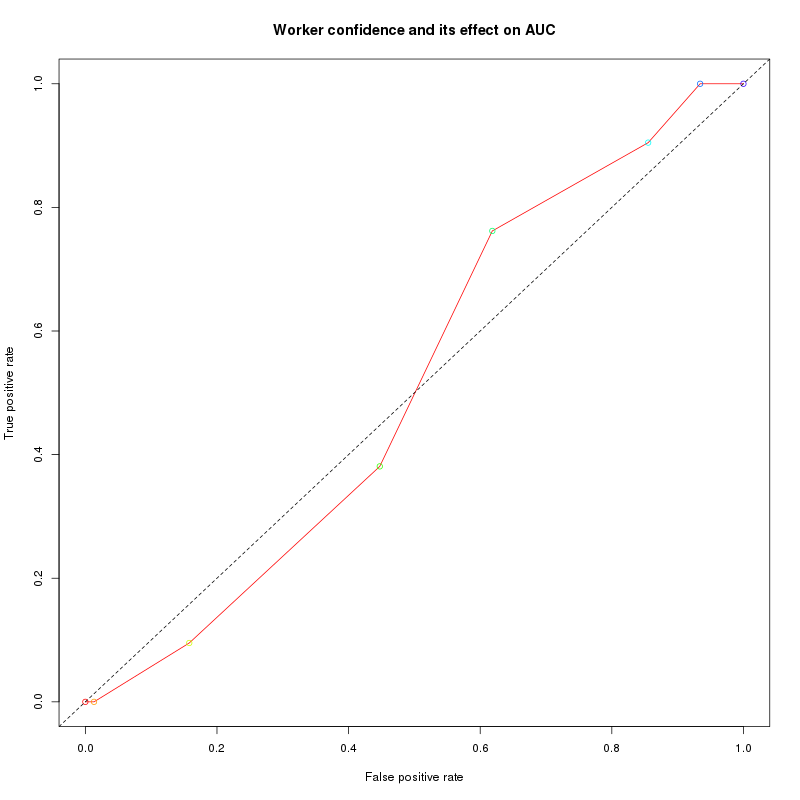

In [63]:
Image(filename = fname)

---

##Different aggregation scheme

We try another result aggregation scheme. Before we were taking the majority vote for each work unit. If 2 people said the relationship was true, but 3 said it was false, then we took the crowd answer as "false".

Now we will try another method: if any of {1, 2, 3, 4, 5} people say that a relationship is true, then we take that relationship to be true, even if more people say it is false.

In [64]:
# take positive votes only, indirect is yes
res_positive_yes = aggregate_results("uniq_id", "verify_relationship", raw_data,
                                    "positive_signal_only", ["pmid", "_unit_id"],
                                    "yes_direct", {"yes_indirect" : "yes_direct"})

In [65]:
# take positive votes only, indirect is no
res_positive_no = aggregate_results("uniq_id", "verify_relationship", raw_data,
                                    "positive_signal_only", ["pmid", "_unit_id"],
                                    "yes_direct", {"yes_indirect" : "no_relation"})

In [66]:
def determine_truth(dataframe):
    """
    Add the in_gold column to each row.
    """
    def is_in_gold(uniq_id):
        res = raw_data.query("uniq_id == '{0}'".format(uniq_id))
        chemical_id = res["drug_id"].iloc[0]
        disease_id = res["disease_id"].iloc[0]
        pmid = res["pmid"].iloc[0]
        
        return int(testset[pmid].has_relation(Relation(pmid, chemical_id, disease_id)))
    
    def chem_id(uniq_id):
        return raw_data.query("uniq_id == '{0}'".format(uniq_id))["drug_id"].iloc[0]

    def dise_id(uniq_id):
        return raw_data.query("uniq_id == '{0}'".format(uniq_id))["disease_id"].iloc[0]
    
    dataframe.loc[:, "in_gold"] = dataframe.loc[:, "uniq_id"].map(is_in_gold)
    dataframe.loc[:, "chemical_id"] = dataframe.loc[:, "uniq_id"].map(chem_id)
    dataframe.loc[:, "disease_id"] = dataframe.loc[:, "uniq_id"].map(dise_id)
    return dataframe

###ROC when indirect votes count as yes:

In [67]:
temp = res_positive_yes.query("verify_relationship == 'yes_direct'")
new_final_yes = determine_truth(temp)

/usr/lib64/python2.7/site-packages/pandas/core/indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/lib64/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [68]:
fname = "data/roc/job_754530_non_majority_metric_indirect_is_yes.png"
title = "ROC for job 754530 (abstract level) testing non-majority voting aggregation (indirect is yes)"
get_AUC_value(new_final_yes, "percent_agree", "in_gold", fname, title)

0.9260651629072681

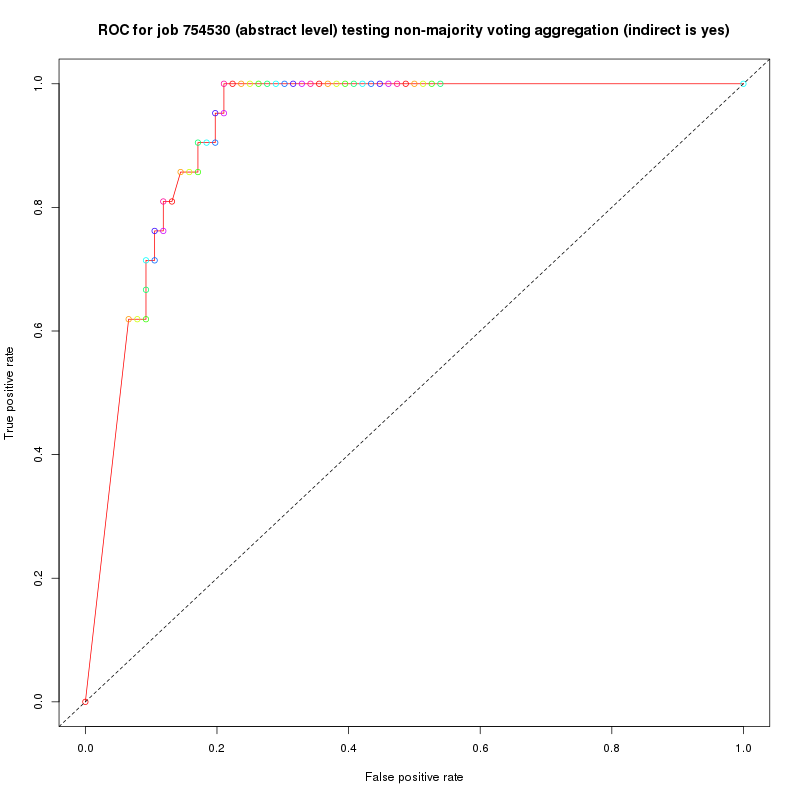

In [69]:
Image(fname)

###ROC when indirect votes are counted as no:

In [70]:
temp = res_positive_no.query("verify_relationship == 'yes_direct'")
new_final_no = determine_truth(temp)

In [71]:
fname = "data/roc/job_754530_non_majority_metric_indirect_is_no.png"
title = "ROC for job 754530 (abstract level) testing non-majority voting aggregation, indirect means no"
get_AUC_value(new_final_no, "percent_agree", "in_gold", fname, title)

0.9329573934837092

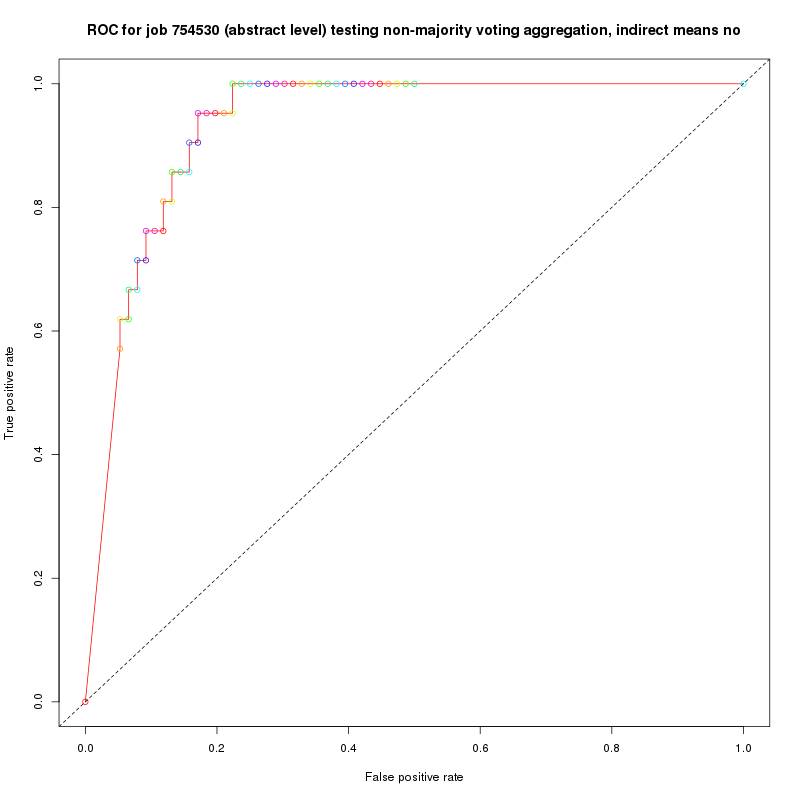

In [72]:
Image(fname)

###Best F scores:

In [73]:
max_F_score("percent_agree", "in_gold", new_final_yes)

F_score      0.724138
precision    0.567568
recall       1.000000
threshold    0.596415
Name: 16, dtype: float64

In [74]:
max_F_score("percent_agree", "in_gold", new_final_no)

F_score      0.740741
precision    0.606061
recall       0.952381
threshold    0.596415
Name: 16, dtype: float64

###Without trust score weighting:

In [75]:
# test without trust score weighting
fname = "data/roc/job_754530_non_majority_metric_indirect_is_yes_unweighted.png"
title = "ROC for job 754530 (abstract level) testing non-majority voting aggregation (indirect is yes); unweighted"
get_AUC_value(new_final_yes, "num_votes", "in_gold", fname, title)

0.9244987468671679

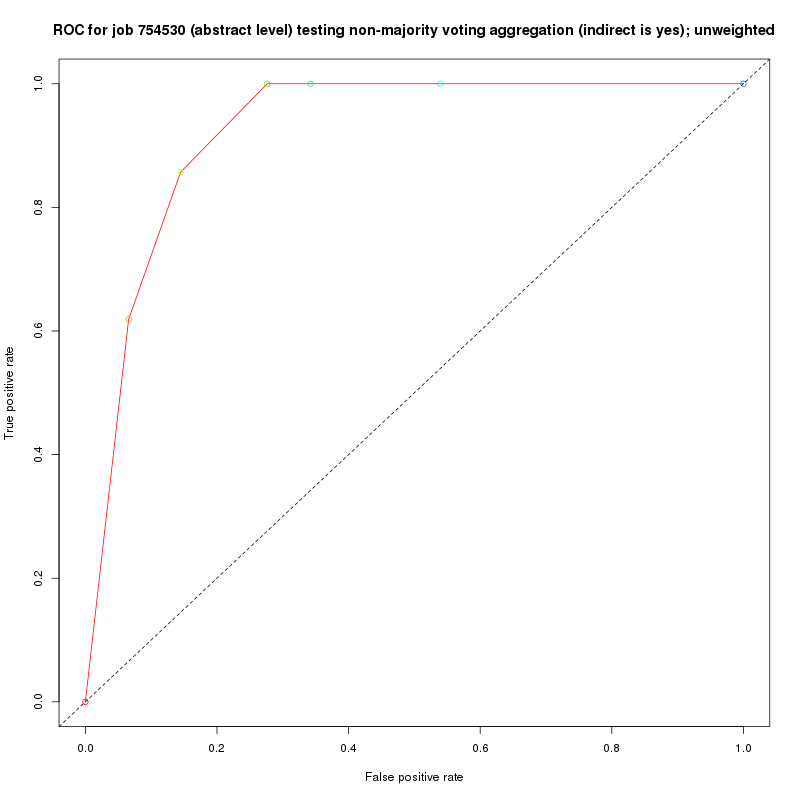

In [76]:
Image(fname)

In [77]:
# test without trust score weighting
fname = "data/roc/job_754530_non_majority_metric_indirect_is_no_unweighted.png"
title = "ROC for job 754530 (abstract level) testing non-majority voting aggregation (indirect is no); unweighted"
get_AUC_value(new_final_no, "num_votes", "in_gold", fname, title)

0.9307644110275689

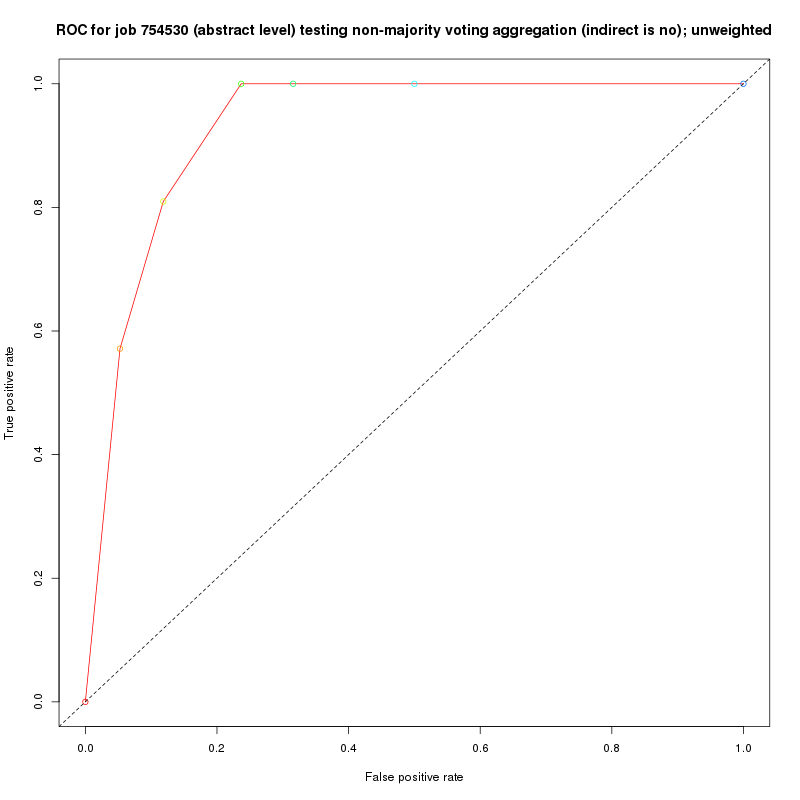

In [78]:
Image(fname)

In [79]:
def plot_results(score_column, class_column, dataframe):
    res = all_F_scores(score_column, class_column, dataframe)
    res = res.sort("threshold")
    
    graph = res.plot(x = "threshold", figsize = (7, 7))
    graph.set_ylim((0, 1.1))

In [80]:
max_F_score("num_votes", "in_gold", new_final_yes)

F_score      0.720000
precision    0.620690
recall       0.857143
threshold    4.000000
Name: 3, dtype: float64

In [81]:
max_F_score("num_votes", "in_gold", new_final_no)

F_score      0.723404
precision    0.653846
recall       0.809524
threshold    4.000000
Name: 3, dtype: float64

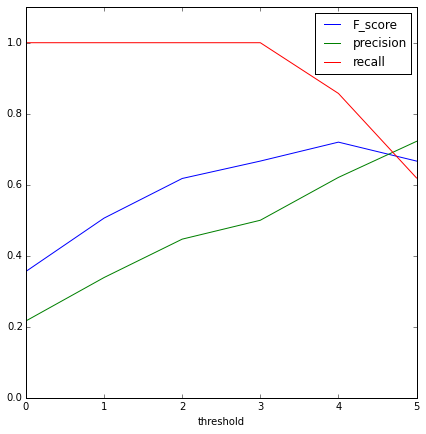

In [82]:
plot_results("num_votes", "in_gold", new_final_yes)

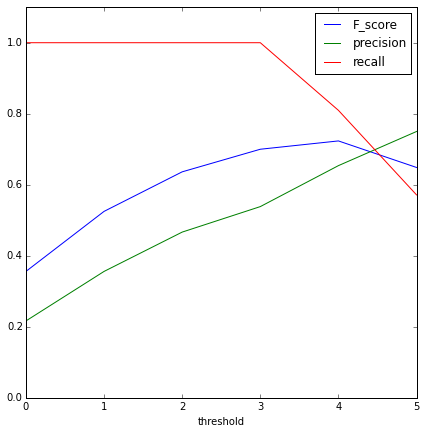

In [83]:
plot_results("num_votes", "in_gold", new_final_no)

From this we see again that indirect relationships do not belong and should be treated as false relationships. The maximum F-score occurs when roughly 60% of the votes are positive, which is similar to what would be the minimum for the majority voting system (3 of 5 votes). From this it seems that there probably isn't too much difference between the two methods. The positive signal method might work better overall for generating the confidence scores in the drug-disease relationship, since the value can occur anywhere between 0 and 1. Using the majority voting scheme, with the score ranging from -1 (everyone votes no) to 1 (everyone votes yes), where negative values mean a no majority, there would be no values from -0.5 to 0.5, since by definition those votes would not be in the majority (at least with a binary judgement).

###Plot of precision, recall, and F-score as a function of the percentage agreement:

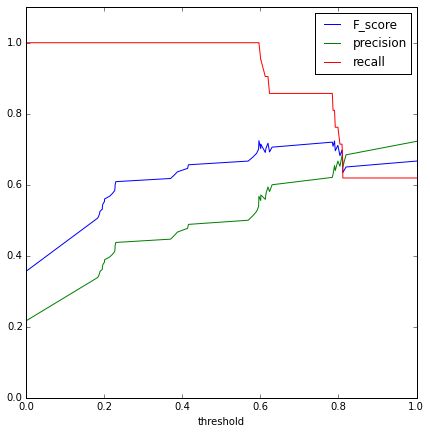

In [84]:
plot_results("percent_agree", "in_gold", new_final_yes)

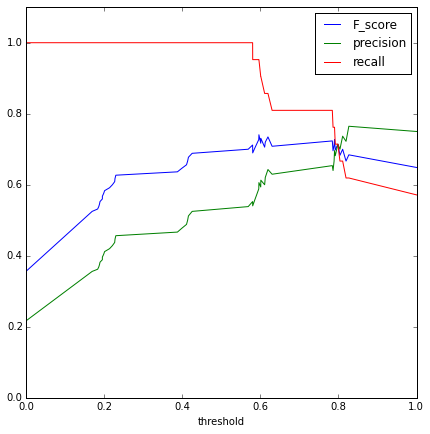

In [85]:
plot_results("percent_agree", "in_gold", new_final_no)

From these data we see that the confidence scoring metrics, majority voting with negative scores and positive signal only, produce the exact same results. Since the positive signal metric is conceptually simpler, it will be the default metric used moving forward.

###Write results to file for use by final aggregator:

In [86]:
new_final_no.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,in_gold,chemical_id,disease_id
0,bcv_hard_0,yes_direct,0.0000,0,0.000000,11569530,756359591,0,C063968,D017180
0,bcv_hard_1,yes_direct,1.6904,2,0.398877,11569530,756359592,0,D020117,D017180
0,bcv_hard_10,yes_direct,4.4417,5,1.000000,11135224,756359601,1,C056507,D013921
0,bcv_hard_11,yes_direct,3.5659,4,0.819446,11135224,756359602,0,C056507,D003643
0,bcv_hard_12,yes_direct,3.3773,4,0.784342,11135224,756359603,1,C056507,D009503


In [87]:
len(new_final_no["uniq_id"].unique())

97

In [88]:
new_final_no.to_csv("data/abstract_level_relations.tsv", sep = '\t', index = False)